In [1]:
import matplotlib.pyplot as plt
from pprint import pprint
import joblib
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from train import save_model, train, get_classifier, evaluate
from model import NNModel
from logit_dataset import LogitDataset

## train

In [4]:
# 527-dim logits
clf = get_classifier(527)

In [9]:
from distillation.data.linked_json import LinkedJsonDatabase

def prepare_datasets(val_ds_name, db_path, embedding_db_path):
    """
    [
    example_id: {'example_id':example_id, 'weak_targets': one-hot, 'logits': logits}
    ]
    """
    emb_db = LinkedJsonDatabase(embedding_db_path)
    db = LinkedJsonDatabase(db_path)
    
    train_ds_name = "train"
    train_logits = np.array([a['logits'] for a in emb_db.get_dataset(train_ds_name).values()])
    validate_logits = np.array([a['logits'] for a in emb_db.get_dataset(val_ds_name).values()])
    return train_logits, validate_logits

In [10]:
from nt_paths import db_root, json_root
target_embedding_db_path = db_root + "/logits/nsynth_ensemble_logits/database.json"
target_db_path = json_root + "/nsynth_pitch_5h.json"
train_logits, validate_logits = prepare_datasets(val_ds_name="valid",
                                            db_path=target_db_path,
                                            embedding_db_path=target_embedding_db_path)
db = LogitDataset(train_logits=train_logits, validate_logits=validate_logits)

/net/home/werning/projects/distillation/distillation/data/linked_json.py:35: UserWarning: No external files referenced, is this a LinkedJsonDatabase file?
  warnings.warn("No external files referenced, is this a LinkedJsonDatabase file?")


In [11]:
db.num_train_samples

19935

In [30]:
## training

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:16<00:00, 23.69it/s]


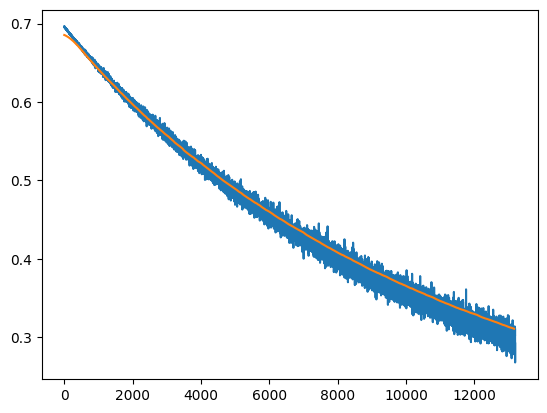

In [12]:
batch_size = 600
clf, train_losses, validate_losses = train(clf,
                                           db,
                                           mixup=0,
                                            batch_size=batch_size,
                                            epochs=400,
                                            lr=1e-4)
epoch_len = db.num_train_samples // batch_size
train_x = range(len(train_losses))
validate_x = epoch_len*np.arange(len(train_losses)//epoch_len)
plt.plot(train_x, train_losses, label='train loss')
plt.plot(validate_x, validate_losses, label='validate_loss')

In [7]:
# clf = joblib.load("/net/vol/werning/storage/relabel_model_tau2022/domain_classifier_no_mixup/model_5.joblib").clf

In [13]:
clf = clf.cuda()

In [ ]:
# compute similarity for all examples
# sort by similarity
# keep x% of examples

In [4]:
from pathlib import Path

from nt_paths import db_root
import joblib
import numpy as np
import re
import paderbox as pb
from concurrent.futures import ProcessPoolExecutor
from distillation.data.linked_json import LinkedJsonDatabase
import torch
from tqdm import tqdm

logit_database_path=db_root + "/relabeling/audioset_full"
db_filename = "database.json"
logit_database_path = Path(logit_database_path)
logit_database_file = logit_database_path / db_filename

assert logit_database_file.exists(), (
    f"logit_database_file {logit_database_file} does not exist",
    logit_database_file,
)

logits = np.load(logit_database_path / "logits.npy")
source_db = pb.io.load(logit_database_file)

In [15]:
# def get_similarity(
#     clf,
#     num_workers,
# ):
#     clf.to(0)

#     def forward(input):
#         out = clf(torch.as_tensor(input).to(torch.float32).to(0))
#         return out.cpu().detach().numpy()

#     batch_size = 10_000
#     dset_len = logits.shape[0]
#     if num_workers > 0:
#         with ProcessPoolExecutor(num_workers) as executor:
#             prediction = np.concatenate(
#                 list(
#                     executor.map(
#                         forward, np.array_split(logits, len(logits) // batch_size)
#                     )
#                 )
#             )
#     else:
#         out = []
#         for inputs in tqdm(np.array_split(logits, len(logits) // batch_size), total=len(logits)//batch_size):
#             out.append(forward(inputs))
#         prediction = np.concatenate(out)
#     assert prediction.shape[0] == dset_len, (
#         prediction.shape,
#         dset_len,
#     )
#     return prediction

# def parse_index(str_val):
#     # hacking linked json db...
#     pattern = re.compile(r"@external\.(?P<file>[a-zA-Z0-9_]+)\[(?P<idx>[0-9]+)\]")
#     match = pattern.match(str_val)
#     if match is None:
#         raise ValueError(str_val)
#     file = match.group("file")
#     idx = int(match.group("idx"))
#     return file, idx

# def get_index(ex):
#     _f, idx = parse_index(ex["logits"])
#     assert _f == "logits", _f
#     # ex.pop("logits")
#     return idx

# def write_top_k_prediction(prediction, proportion, output_path):
#     out_filename = "database.json"
#     output_path = Path(output_path)
#     output_path_file = output_path / out_filename
#     if not output_path.exists():
#         output_path.mkdir(parents=True)
#     assert not output_path_file.exists(), (
#         f"output_path_db {output_path_file} already exists",
#         output_path_file,
#     )
#     # prediction: sort by
#     num  = int(len(prediction)*proportion)
#     top_idx = set(np.argpartition(prediction[:,0], -num)[-num:])

#     def add_example(ex_id, ex, dataset):
#         index = get_index(ex)
#         if index in top_idx:
#             # balancing keys
#             ex["event_ids"] = ex["event_ids"]
#             ex["logits"] = logits[index]
#             dataset[ex_id] = ex

#     new_json = {}
#     for dset_name, dataset in source_db["datasets"].items():
#         new_dataset = {}
#         for ex_id, ex in tqdm(dataset.items(), total=len(dataset)):
#             if "logits" in ex:
#                 add_example(ex_id, ex, new_dataset)
#             else:
#                 raise ValueError(ex)
#         new_json[dset_name] = new_dataset
#     new_db = {"datasets": new_json}
#     LinkedJsonDatabase.save(new_db, output_path_file)

In [15]:
def get_similarity(
    clf,
    num_workers,
):
    clf.to(0)

    def forward(input):
        out = clf(torch.as_tensor(input).to(torch.float32).to(0))
        return out.cpu().detach().numpy()

    batch_size = 10_000
    dset_len = logits.shape[0]
    if num_workers > 0:
        with ProcessPoolExecutor(num_workers) as executor:
            prediction = np.concatenate(
                list(
                    executor.map(
                        forward, np.array_split(logits, len(logits) // batch_size)
                    )
                )
            )
    else:
        out = []
        for inputs in tqdm(np.array_split(logits, len(logits) // batch_size), total=len(logits)//batch_size):
            out.append(forward(inputs))
        prediction = np.concatenate(out)
    assert prediction.shape[0] == dset_len, (
        prediction.shape,
        dset_len,
    )
    return prediction

def parse_index(str_val):
    # hacking linked json db...
    pattern = re.compile(r"@external\.(?P<file>[a-zA-Z0-9_]+)\[(?P<idx>[0-9]+)\]")
    match = pattern.match(str_val)
    if match is None:
        raise ValueError(str_val)
    file = match.group("file")
    idx = int(match.group("idx"))
    return file, idx

def get_index(ex):
    _f, idx = parse_index(ex["logits"])
    assert _f == "logits", _f
    # ex.pop("logits")
    return idx

def write_top_k_prediction(prediction, proportion, output_path):
    out_filename = "database.json"
    output_path = Path(output_path)
    output_path_file = output_path / out_filename
    if not output_path.exists():
        output_path.mkdir(parents=True)
    assert not output_path_file.exists(), (
        f"output_path_db {output_path_file} already exists",
        output_path_file,
    )

    train_predictions = []
    example_ids = []
    
    for dset_name in ['balanced_train', 'unbalanced_train']:
        dataset = source_db['datasets'][dset_name]
        for ex_id, ex in dataset.items():
            example_ids.append(ex_id)
            if not isinstance(ex['logits'], str):
                print(dset_name, ex_id)
            index = get_index(ex)
            train_predictions.append(prediction[index])
    train_predictions = np.stack(train_predictions)
    # prediction: sort by
    num = int(len(train_predictions)*proportion)
    top_idx = set(np.argpartition(train_predictions[:,0], -num)[-num:])

    def add_example(ex_id, ex, dataset):
        index = get_index(ex)
        # balancing keys
        # ex["event_ids"] = ex["event_ids"]
        new_ex = {k:v for k,v in ex.items()}
        new_ex["logits"] = logits[index]
        dataset[ex_id] = new_ex

    new_json = {}
    for dset_name in ["balanced_train", "unbalanced_train", "eval"]:
        dataset = source_db['datasets'][dset_name]
        new_dataset = {}
        if dset_name == "eval":
            for ex_id, ex in dataset.items():
                add_example(ex_id, ex, new_dataset)
        else:
            for idx in tqdm(top_idx, total=len(top_idx)):
                ex_id = example_ids[idx]
                if ex_id in dataset:
                    ex = dataset[ex_id]
                    add_example(ex_id, ex, new_dataset)
        new_json[dset_name] = new_dataset
    new_db = {"datasets": new_json}
    LinkedJsonDatabase.save(new_db, output_path_file)

In [9]:
prediction = get_similarity(clf=clf, num_workers=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:04<00:00, 41.37it/s]


In [10]:
prediction.shape

(1833973, 1)

In [11]:
# prediction = np.load("nsynth_similarity.npy")
np.save("nsynth_similarity.npy", prediction)

In [ ]:
# 10% of audioset

In [16]:
write_top_k_prediction(prediction, proportion=0.1, output_path=db_root + f"/relabeling/dcase_workshop/nsynth_10")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181410/181410 [00:00<00:00, 304635.25it/s]


In [ ]:
# 5% of audioset

In [17]:
write_top_k_prediction(prediction, proportion=0.05, output_path=db_root + f"/relabeling/dcase_workshop/nsynth_5")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90705/90705 [00:00<00:00, 246824.45it/s]


In [ ]:
# save model (no threshold)

In [20]:
p = Path("/net/vol/werning/storage/domain_classifier/nsynth/")
p.mkdir(exist_ok=True, parents=True)
joblib.dump(clf, p/f"clf.joblib")

['/net/vol/werning/storage/domain_classifier/nsynth/clf.joblib']

In [8]:
p = Path("/net/vol/werning/storage/domain_classifier/nsynth/")
clf = joblib.load(p/"clf.joblib")